# Create a raster mask using the ALUM 2013 dataset

**What does this notebook do?** This notebook demonstrates how to create a raster mask using a shapefile. It uses `rasterio` to 'burn' the polygon extent of each feature from a shapefile into a new raster, based off the extent of a Geotiff. In this case, it uses the [NSW Land Use Mask 2013 dataset](http://data.environment.nsw.gov.au/dataset/nsw-landuse-2013) to generate a raster that covers the extent of the Namoi River catchment.

The Land Use Mask dataset is first preprocessed in QGIS to remove superfluous polygons, so that just Irrigated Cropping polygons remain. The steps for the pre-processing are captured below.

**Outputs:**
This code was run twice to produce two datasets:
- `ALUM2013_Crop_Namoi_mask.pkl` - includes all cropping polygons
- `ALUM2013_IrrCrop_Namoi_mask.pkl` - only irrigated cropping polygons


**Date:** May 2018

**Author:** Claire Krause

## QGIS Preprocessing

### For ease, the ALUM polygon set was preprocessed in QGIS before being loaded in here. 

Add the `/g/data/r78/cek156/dea-notebooks/Land_NSW_Landuse_2013/Data/Shapefile/NSW_Landuse_2013.shp` polygon set, and `/g/data/r78/namoi/Namoi_catchment.shp` to a new QGIS project.  


### To clip the NSW Landuse file using the Namoi catchment extent
Vector -> Geoprocessing Tools -> Clip -> input vector file (`NSW_Landuse_2013`) -> clip layer (`Namoi_catchment`) -> output shapefile (tmp).


### Just cropping 
The following classes from the attribute table were manually selected:

| Code | Description |
|------|-------------|
| 3.3.0 | Cropping |
| 4.3.0 | Irrigated cropping |

- `/g/data/r78/cek156/dea-notebooks/Crop_mapping/ALUM2013_Crop_Namoi.shp` - 3.3.0 and 4.3.0
- `/g/data/r78/cek156/dea-notebooks/Crop_mapping/ALUM2013_IrrCrop_Namoi.shp` - just 4.3.0

In [1]:
%pylab notebook

import xarray as xr
import rasterio
import rasterio.features
import geopandas as gp
import glob
import pickle

Populating the interactive namespace from numpy and matplotlib


## Read in the NSW Landuse shapefile, and any Namoi Geotiff (just to grab extents for the mask)

In [2]:
shape_file = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/ALUM2013_Crop_Namoi.shp'

In [3]:
StatsFile = '/g/data/r78/cek156/datacube_stats/Namoi_summer/NDVI/withls7/ndvi_None_20131101.tif'

### We need to re-open the NDVI file with rasterio, and the shapefile with geopandas (not the most elegant solution, but it works)

In [4]:
GeotiffData_rasterio = rasterio.open(StatsFile)

# Open the Geotiff so we can get the x and y coordinates for later on
GeotiffData = xr.open_rasterio(StatsFile)

In [5]:
shp = gp.read_file(shape_file)

# Reproject coordinate system of shape file
shp = shp.to_crs({'init': 'epsg:3577'})

I am densified (external_values, 736 elements)


### Iterate over each of the polygons, and put a '1' in the mask raster that corresponds to the footprint of each polygon

In [6]:
mask = rasterio.features.rasterize(((feature['geometry'], 1) for feature in shp.iterfeatures()),
                                   out_shape=GeotiffData_rasterio.shape,
                                   transform=GeotiffData_rasterio.transform)

In [7]:
# Convert '0' values to 'nan'
mask = mask.astype('float_')
mask[mask == 0] = np.nan

In [8]:
# Convert the numpy array to a DataArray
mask = xr.DataArray(mask, coords=(GeotiffData.y, GeotiffData.x))

<IPython.core.display.Javascript object>


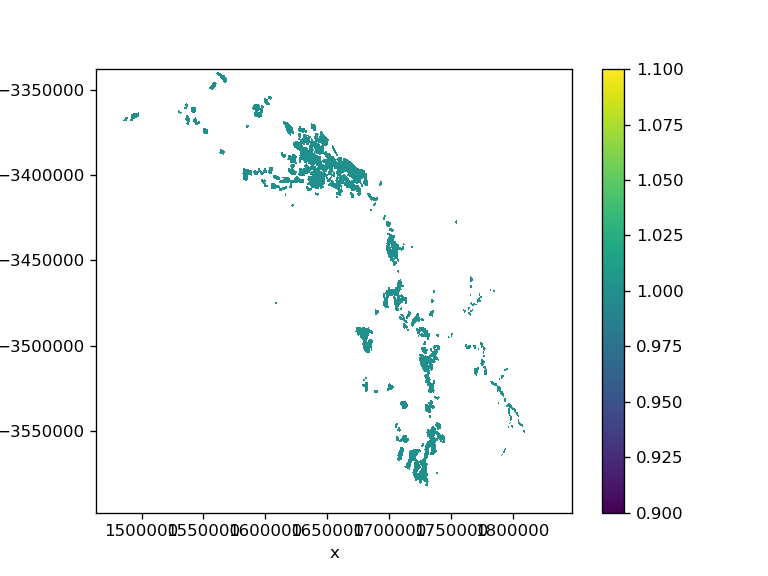

In [9]:
plt.figure()
mask.isel(x=range(0, len(GeotiffData.x), 10),
          y=range(0, len(GeotiffData.y), 10)).plot();

### Pickle out the mask for later on

In [10]:
with open('ALUM2013_Crop_Namoi_mask.pkl', 'wb') as f:
    pickle.dump(mask, f, -1)